# The impact of mass drug administration on trachoma prevalence in Ethiopia (Comparison of cox proportional hazard regression and machine learning models)

## Objective of the study 

The main purpose of this article is to investigate the impact of mass drug administration on trachoma prevalence in Ethiopia.  The study also specifically 
   * Identify risk factors associated with trachoma prevalence in Ethiopia
   * to compare two models (Cox proportional hazards model and Random survival forest model) to estimate the survival probability given a set of features/covariables.


## Description of the data 

The study used secondary data obtained from -------------- . the data contains records of more than 700 districts in ethiopia. however, only 377 of the districts were able to included in this particular study. those districts that have not completed atleast one impact survey were excluded becuase of problems in data accuracy and consistency.

The time to duration variable is MDA round and the event_ censorship variable is current tf value. if the tv value is less than or equalt to 5, it is considered as *event* otherwise it is *censored*.  

The independent variables(covariates) included are 
   * average MDA coverage 
   * wash coverage 
   * impact survey one tf value ( prevalence)
   * latrine coverage 
   * MDA skip 
   * MDA delay 

## Methods 

### The Ph regression model. 
The Ph regression model is one of the most widely statistical method used to model time to event variable with one or more covariates. The Cox Proportional Hazards Model was introduced by Cox and it takes into account the effect of several variables at a time and examines the relationship of the survival distribution to these variables. For these particualr study, the cox proportional hazard model was used to predict the mda round needed by districts to achieve a tf value of less than 5 from a sets of covariates measured at distict level. 

### Random survival forest model

Survival data are commonly analyzed using methods that rely on restrictive assumptions such as proportional hazards. Further, because these methods are often parametric, nonlinear effects of variables must be modeled by transformations or expanding the design matrix to include specialized basis functions.Often ad hoc approaches, such as stepwise regression, are used to determine ifnonlinear effects exist. Identifying interactions, especially those involving multiple variables, is also problematic. This must be done by brute force (examining alltwo-way and three-way interactions, e.g.), or must rely on subjective knowledge to narrow the search.
In contrast, these difficulties are handled automatically using forests.

In [1]:
cd C:\\Users\\AII\\desktop\\trach_377

C:\Users\AII\desktop\trach_377


# library importing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import WeibullAFTFitter,LogLogisticAFTFitter,LogNormalAFTFitter
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

# read the data to python

In [3]:
df = pd.read_csv("final_377.csv")

# varaibales included in the data 

In [4]:
df.columns

Index(['region', 'district', 'sub_district', 'gioconnect_id', 'tf_original',
       'tf', 'impact_survey_1_tf', 'mda_skip', 'mda_skip_years',
       'mda_skip_year', 'Years_Before_Treatment_Start',
       'Years_Before_Treatment_Startt', 'mda_delay', 'mda_round',
       ' average_coverage  ', '  wash_imp_percent  ', ' wash_near_percent  ',
       '    latrine_imp_percent    ', ' wash_imp_yard_percent ',
       ' wash_imp_30_percent '],
      dtype='object')

# the first 5 rows

In [5]:
df.head()

,region,district,sub_district,gioconnect_id,tf_original,tf,impact_survey_1_tf,mda_skip,mda_skip_years,mda_skip_year,Years_Before_Treatment_Start,Years_Before_Treatment_Startt,mda_delay,mda_round,average_coverage,wash_imp_percent,wash_near_percent,latrine_imp_percent,wash_imp_yard_percent,wash_imp_30_percent
0,Afar,Awsa,Aregoba,6113,12.4,0,1,yes,1,1,4,3,yes,2,94%,37%,0.23,6%,0.11,0.14
1,Afar,Awsa,Awash fentale,6123,5.2,0,0,yes,1,1,4,3,yes,2,94%,72%,0.48,5%,0.23,0.43
2,Amhara,Awi,Ankesha Guagusa,6261,15.6,0,1,no,0,0,0,0,no,15,74%,45%,0.42,NaN,0.02,0.27
3,Amhara,Awi,Ayehu,19521,18.4,0,1,no,0,0,0,0,no,16,96%,66%,0.31,2%,0.01,0.23
4,Amhara,Awi,Banja Shikudad,6278,4.0,1,2,no,0,0,0,0,no,11,98%,77%,0.50,2%,0.02,0.42


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   region                         377 non-null    object 
 1   district                       377 non-null    object 
 2   sub_district                   377 non-null    object 
 3   gioconnect_id                  377 non-null    int64  
 4   tf_original                    377 non-null    float64
 5   tf                             377 non-null    int64  
 6   impact_survey_1_tf             377 non-null    int64  
 7   mda_skip                       377 non-null    object 
 8   mda_skip_years                 377 non-null    int64  
 9   mda_skip_year                  377 non-null    int64  
 10  Years_Before_Treatment_Start   377 non-null    int64  
 11  Years_Before_Treatment_Startt  377 non-null    int64  
 12  mda_delay                      377 non-null    obj

## data Cleaning 

In [7]:
# convert to string 
df['wash_improved_percent'] = df['  wash_imp_percent  '].astype(str)
df['latrine_improved_percent'] = df['    latrine_imp_percent    '].astype(str)
df["mda_delay"] = df["mda_delay"].replace({'no':1, 'yes':0}, regex = True)
 # replacing characters 
chars_to_remove = ['%']
# Replace each character with an empty string
for char in chars_to_remove:
    df['AV'] = df[' average_coverage  '].apply(lambda x: x.replace(char, ''))
    df['wash_improved_percent'] = df['wash_improved_percent'].apply(lambda x: x.replace(char, ''))
    df['latrine_improved_percent'] = df['latrine_improved_percent'].apply(lambda x: x.replace(char, ''))
 # Convert to int   
df['AV'] = df['AV'].astype(int)
df['wash_improved_percent'] = df['wash_improved_percent'].astype(float)
df['latrine_improved_percent'] = df['latrine_improved_percent'].astype(float)

# checking for missing values 

In [8]:
df.isnull().sum()

region                            0
district                          0
sub_district                      0
gioconnect_id                     0
tf_original                       0
tf                                0
impact_survey_1_tf                0
mda_skip                          0
mda_skip_years                    0
mda_skip_year                     0
Years_Before_Treatment_Start      0
Years_Before_Treatment_Startt     0
mda_delay                         0
mda_round                         0
 average_coverage                 0
  wash_imp_percent               43
 wash_near_percent               43
    latrine_imp_percent          57
 wash_imp_yard_percent           44
 wash_imp_30_percent             43
wash_improved_percent            43
latrine_improved_percent         57
AV                                0
dtype: int64

# missing values imputting using average 

In [9]:
df['wash_improved_percent'] = df['wash_improved_percent'].fillna(df['wash_improved_percent'].mean())
df['latrine_improved_percent'] = df['latrine_improved_percent'].fillna(df['latrine_improved_percent'].mean())

# create dummy variables of the categorical variables 

In [10]:
df = pd.get_dummies(df, columns = ['impact_survey_1_tf','mda_skip'])

# slicing a subset of variables from data set( variables only used for the analysis)

In [11]:
df = df[['region','tf', 'mda_skip_yes','impact_survey_1_tf_1','impact_survey_1_tf_2','mda_delay', 'mda_round', 'AV','wash_improved_percent', 'latrine_improved_percent','tf_original']]

#  data visualization 

Text(0, 0.5, 'tf value of districts')

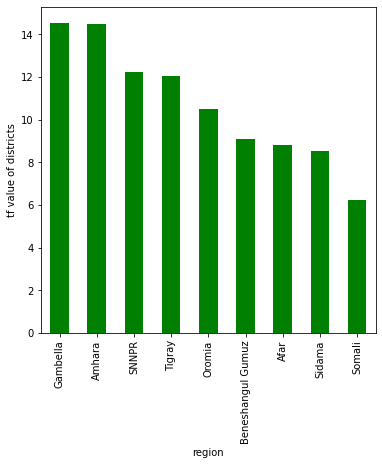

In [12]:
# bar chaer for the number of districts in the region 
df.groupby('region')["tf_original"].mean().sort_values(ascending=False).plot(kind = 'bar',color = 'green',figsize = (6,6))
plt.ylabel('tf value of districts')

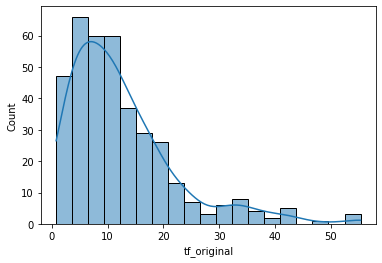

In [13]:
# histogram of the tv value of districts 
sns.histplot(df["tf_original"], kde = True)
plt.show()

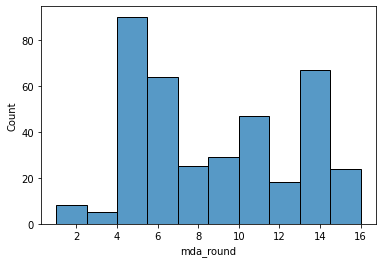

In [14]:
# histogram of the time variable(mda round) to get an overall idea of the distribution
sns.histplot(df["mda_round"], kde = False)
plt.show()

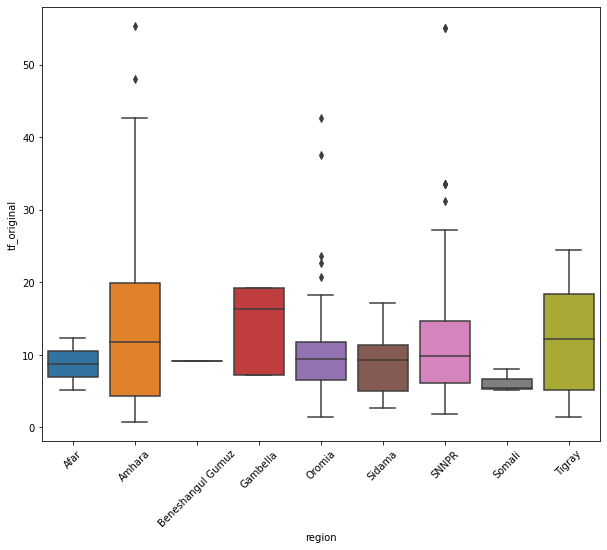

In [15]:
#plot a histogram of the time variable(mda round) to get an overall idea of the distribution. 
plt.figure(figsize = (10,8))
sns.boxplot(x = 'region', y  = 'tf_original',data = df)
plt.xticks(rotation = 45)
plt.show()

# The survival function 

To start with survival analysis, Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

The median survival time : 16.0


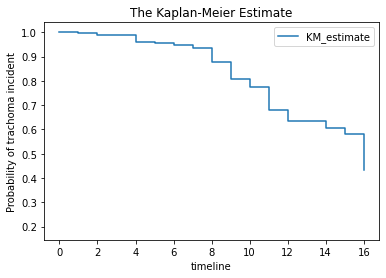

In [16]:
kmf = KaplanMeierFitter()
kmf.fit(durations =  df["mda_round"], event_observed = df["tf"])
print("The median survival time :",kmf.median_survival_time_)
kmf.plot_survival_function(ci_alpha = 0.001)
plt.title("The Kaplan-Meier Estimate")
plt.ylabel("Probability of trachoma incident")
plt.show()

Kaplan–Meier estimates were used to construct the survival function for the prevalence of trachoma at districts. From the Figure , the median mda round was found to be 16, which indicates that 50% of the districts registered trachoma tf value less than 5 before or at  16 mda round, and the other 50% was not able to until 16 mda round.

<AxesSubplot:title={'center':'Survival of different region'}, xlabel='timeline'>

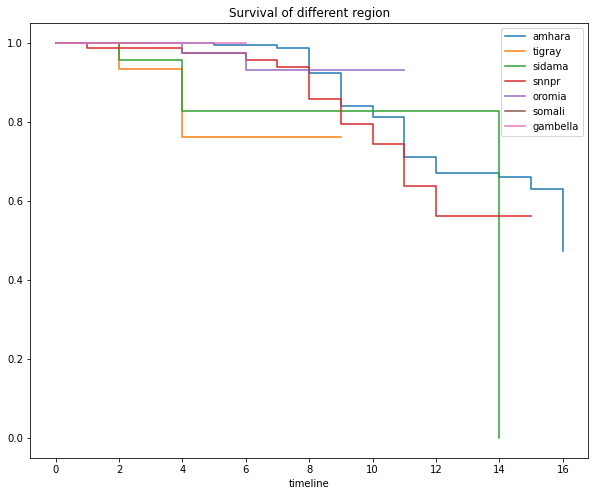

In [17]:
# The kaplan_ meier estimate across region
T = df["mda_round"]
E = df["tf"]
fig, ax = plt.subplots(figsize=(10, 8))
M = (df["region"] == 'Amhara')
kmf.fit(durations = T[M], event_observed = E[M], label = "amhara")
kmf.plot_survival_function(ax = ax,ci_show = False)
G = (df["region"] == 'Tigray')
kmf.fit(durations = T[G], event_observed = E[G], label = "tigray")
kmf.plot_survival_function(ax = ax,ci_show = False)
S = (df["region"] == 'Sidama')
kmf.fit(durations = T[S], event_observed = E[S], label = "sidama")
kmf.plot_survival_function(ax = ax,ci_show = False)
N = (df["region"] == 'SNNPR')
kmf.fit(durations = T[N], event_observed = E[N], label = "snnpr")
kmf.plot_survival_function(ax = ax,ci_show = False)
O = (df["region"] == 'Oromia')
kmf.fit(durations = T[O], event_observed = E[O], label = "oromia")
kmf.plot_survival_function(ax = ax,ci_show = False)
K = (df["region"] == 'Somali')
kmf.fit(durations = T[K], event_observed = E[K], label = "somali")
kmf.plot_survival_function(ax = ax,ci_show = False)
plt.title("Survival of different region")
J = (df["region"] == 'Gambella')
kmf.fit(durations = T[J], event_observed = E[J], label = "gambella")
kmf.plot_survival_function(ax = ax,ci_show = False)

## Cox proportional hazards
The conventional multiple CPH regression is performed to identify the factors associated with districts tv value. The CPH model is a semiparametric approach that computes the impact of a set of given covariates (i.e., features) on the hazard (i.e., risk) of an event occurring (in our case, tv value less than 5). In this case, the hazard of a of a district is a linear function of a population baseline hazard (that changes over mda round) and other predictor covariates (multiplied by their corresponding coefficients). 

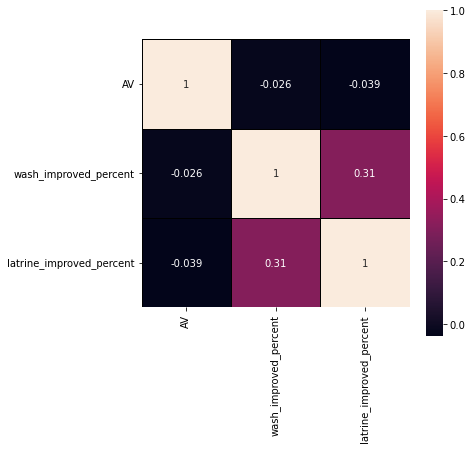

In [18]:
# perform correlation among continues covariates 
d = df[['AV', 'wash_improved_percent', 'latrine_improved_percent']]
fig , ax1 = plt.subplots(figsize = (6,6))
fig = sns.heatmap(d.corr(),annot = True, linewidths =1 , linecolor = 'k',square = True, mask = False, cbar = True)

The above correlation matrix clearly shows us there is no significant relation ship among covariates.therefore multicolinearity is not a problem in this model.

In [19]:
# instaniate and fit the model and print model summary 
cox = CoxPHFitter(alpha = 0.05)
cox.fit( df = df, duration_col = 'mda_round', event_col ='tf', formula ="AV  + impact_survey_1_tf_1 + impact_survey_1_tf_2 + mda_delay + mda_skip_yes + latrine_improved_percent + wash_improved_percent")
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 377 total observations, 293 right-censored observations>
             duration col = 'mda_round'
                event col = 'tf'
      baseline estimation = breslow
   number of observations = 377
number of events observed = 84
   partial log-likelihood = -378.53
         time fit was run = 2022-08-02 13:36:45 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
AV                         0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
impact_survey_1_tf_1      -1.22       0.29       0.25            -1.70            -0.74                 0.18                 0.48
impact_survey_1_tf_2      -2.41       0.09       0.43            -3.24            -1.58                 0.04                 0.21
latrine_improved_percent   0.02       1.02       0.01             0.00             0.04                 1.00                 1.04
mda_delay                 -0.55       0.58       0.24            -1.02            -0.08                 0.36                 0.92
mda_skip_yes              -0.49       0.61       0.23            -0.94            -0.04                 0.39                 0.96
wash_improved_percent      0.02       1.02       0.01             0.00             0.03                 1.00                 1.04

                           cmp to     z      p   -log2(p)
covariate                                                
AV                           0.00  2.14   0.03       4.93
impact_survey_1_tf_1         0.00 -4.98 <0.005      20.57
impact_survey_1_tf_2         0.00 -5.67 <0.005      26.08
latrine_improved_percent     0.00  2.23   0.03       5.28
mda_delay                    0.00 -2.30   0.02       5.54
mda_skip_yes                 0.00 -2.14   0.03       4.94
wash_improved_percent        0.00  2.32   0.02       5.61
---
Concordance = 0.84
Partial AIC = 771.06
log-likelihood ratio test = 103.96 on 7 df
-log2(p) of ll-ratio test = 62.40

In [20]:
f = df[df['region']=='Somali']
cox.predict_median(f)


344    11.0
345     9.0
346     9.0
Name: 0.5, dtype: float64

### P- Values and Statistical Significance
As indicated above, the final model contains:average coverage, impact survey one result, latrine improved percentage, wash improved percentage, mda skip and mda delay. Covariates such as average coverage (0.02, 95% CI:0.00, 0.03), impact_survey_one_tf_result(10 to 29.9) (-1.22, 95% CI: -1.7, -0.74), impact_survey_one_tf_result(greator than 30) (-2.41,95% CI: -3.24,-1.58), latrine_improved_percent (0.02, 95% CI:0.00, 0.04), mda_delay(-0.55,95% CI:-1.02,-0.08),mda_skip_yes(-.49,95% CI: -.94,-0.04) and wash_improved_percent(0.02, 95% CI:0.00, 0.03) are all statistically significant at 5% level of significance.

## coefficient interpretation

The coefficient associated with **average mda covarage**is posetive which indicates that increasing mda coverage result in decreasing trachoma prevalence at district level. To be more specific, a hazard ratio of 1.02 shows that the probability of districts tf prevalence to be below 5% increases by 1.9% for every one percent increases in mda coverage keeping all other covariates constant. 

The coefficient associated with **impact_survey_result( 10 - 29.9)** is negative which indicates that districts that recorded a tf value 10 to 29.9 at impact survey one has lower probalility to have current tf value less than 5% than districts that recorded 5 to 10 at impact survey one considering all other covariates constant. That is the probability of districts that recorded 10 to 29.9 in impact survey one to have current tf value less that 5 decreases by 244.8%. 

The coefficient associated with **impact_survey_result( greater than 30)** is negative which indicates that districts that recorded a tf value greater than 30 at impact survey one has lower probalility of having current tf value less than 5 than districts that recorded 5 to 10 at impact survey one considering all other covariates constant. That is the probability of districts that recorded greater than 30 in impact survey one to have current tf value less that 5 decreases by 1011%. 

The coefficient associated with **mda delay(yes)** is negative which indicates that districts that delay MDA at leat one year has lower probalility to have current tf value less than 5 than districts did not delay MDA keeping all other covariates constant. That is the probability of districts that delay MDA to have current tf value less than 5 decreases by 72%. 

The coefficient associated with **mda skip(yes)** is negative which indicates that districts that skip MDA at leat one year has lower probalility of having current tf value less than 5 than districts did not skip MDA keeping all other covariates constant. That is the probability of districts that skip MDA to have current tf value less that 5 decreases by 63%. 

The other covariates with hazard ratio greater than 1 is **latrine improved percent**. This is an indication that increasing latrine percentage for districts will decreases trachoma prevalence. To be more specific, a hazard ratio of 1.023 shows that the probability of districts to have a tf value less than 5 increases by 2 % for every one percent increases in latrine improved percentage keeping all other covariates constant. 

**wash improved percent** has also hazard ratio greater than 1. Accordingly,increasing wash percentage is associated with decreasing trachoma prevalence. That is , a hazard ratio of 1.02 shows that the probability of districts to have a tf value less than 5 increases by 1.98 % for every one percent increases in wash improved percentage keeping all other covariates constant. 

<AxesSubplot:xlabel='log(HR) (95% CI)'>

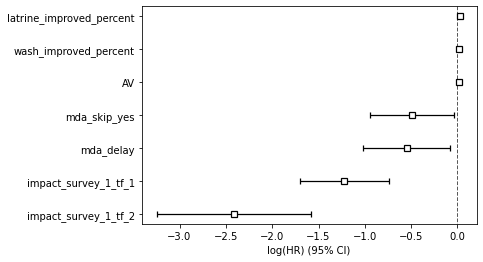

In [21]:
# plotting the model
cox.plot()

In [22]:
# The proportional hazard assumption
import eli5
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cox, df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 377 total observations, 293 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic    p  -log2(p)
AV                                  0.19 0.66      0.60
impact_survey_1_tf_1                1.43 0.23      2.11
impact_survey_1_tf_2                1.49 0.22      2.17
latrine_improved_percent            0.43 0.51      0.97
mda_delay                           2.67 0.10      3.29
mda_skip_yes                        2.05 0.15      2.72
wash_improved_percent               0.36 0.55      0.86

In [23]:
cox.check_assumptions(df,p_value_threshold=0.05,show_plots=True)

Proportional hazard assumption looks okay.


C:\Users\AII\anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

Incorporating variable(s) not satisfying the PH assumption leads to an inferior fit of a Cox model, that is, the power of test is reduced for both variables with constant and nonconstant HR in the model. The table above reveals the  values of the tests based on the scaled Schoenfeld residuals for nonproportional hazard assessment. The results of the test does not provide enough evidence of deviation from the proportionality assumption. This is because all of the  values for testing whether the correlation between Schoenfeld residual for these covariates and ranked survival time is not less than 0.05.

### Partial effect of the covariate 

The following graph shows partial effect of the covariate **mda skip**. The median of mda round for those that did not skip mda is lower than of those who miss mda at least for one year. 

<AxesSubplot:>

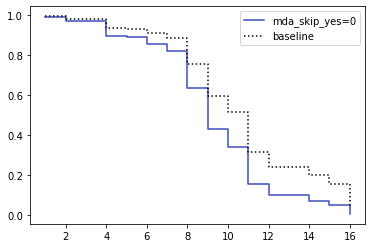

In [24]:
cox.plot_partial_effects_on_outcome(covariates = 'mda_skip_yes', values = [0], cmap = 'coolwarm')

The following graph shows partial effect of latrine improved percentage at different values. That is the survival function for different valus of latrine improved keeping all other covariates constant.As indicated in the coefficient summary table, the increase in latrine improved percentage decrases the median mda round.  

<AxesSubplot:>

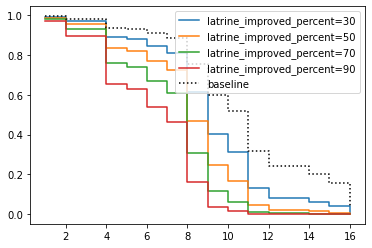

In [25]:
cox.plot_covariate_groups(covariates=['latrine_improved_percent'],values=[30,50,70,90])

<AxesSubplot:>

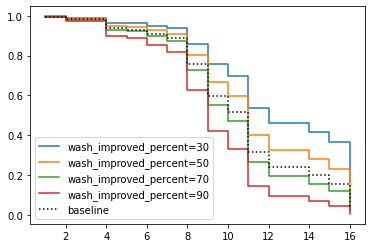

In [26]:
cox.plot_covariate_groups(covariates=['wash_improved_percent'],values=[30,50,70,90])

The graph above shows partial effect of wash improved percentage at different values. That is the survival function for different values of wash improved keeping all other covariates constant.As indicated in the coefficient summary table, the graph also shows that increase in wash improved percentage decrases the median mda round. 

<AxesSubplot:>

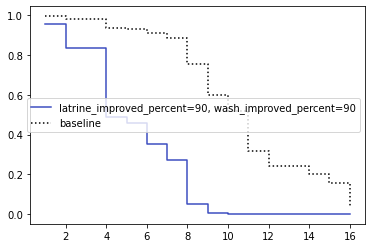

In [27]:
cox.plot_partial_effects_on_outcome(covariates=['latrine_improved_percent', 'wash_improved_percent'],
    values=[[90, 90],], cmap='coolwarm')

# The AFT model 

Although the Cox proportional-hazards (PH) model is the most employed technique in survival analysis because of its reduced set of assumptions about the baseline hazard function, formulation of the accelerated failure-time (AFT) model allows the derivation of a time ratio, which is more interpretable than a ratio of two hazards. The AFT model doesn’t require PH assumption which is seldom met assumption of the Cox PH model. It also encompasses relatively a wide range of survival time distributions and yields more powerful estimates than the Cox PH model, provided that method imposed assumptions satisfied.To select the best model for trachoma incidence, different AFT model based on distribution is performed 

# Weibull AFT model 

In [28]:
wf = WeibullAFTFitter().fit( df = df, duration_col = 'mda_round', event_col ='tf', formula ="AV + impact_survey_1_tf_1 + impact_survey_1_tf_2 + mda_delay + mda_skip_yes + latrine_improved_percent + wash_improved_percent")
print(wf.print_summary())

<lifelines.WeibullAFTFitter: fitted with 377 total observations, 293 right-censored observations>
             duration col = 'mda_round'
                event col = 'tf'
   number of observations = 377
number of events observed = 84
           log-likelihood = -301.68
         time fit was run = 2022-08-02 13:36:51 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                        
lambda_ Intercept                  3.16      23.53       0.31             2.54             3.77                12.71                43.57
        AV                        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        impact_survey_1_tf_1       0.37       1.45       0.08             0.22             0.53                 1.25                 1.69
        impact_survey_1_tf_2       0.74       2.10       0.14             0.47             1.01                 1.60                 2.75
        latrine_improved_percent  -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        mda_delay                  0.17       1.18       0.07             0.03             0.31                 1.03                 1.36
        mda_skip_yes               0.15       1.16       0.07             0.00             0.29                 1.00                 1.34
        wash_improved_percent     -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
rho_    Intercept                  1.16       3.20       0.08             1.01             1.32                 2.74                 3.73

                                   cmp to     z      p   -log2(p)
param   covariate                                                
lambda_ Intercept                    0.00 10.05 <0.005      76.48
        AV                           0.00 -2.04   0.04       4.61
        impact_survey_1_tf_1         0.00  4.79 <0.005      19.17
        impact_survey_1_tf_2         0.00  5.39 <0.005      23.80
        latrine_improved_percent     0.00 -2.16   0.03       5.02
        mda_delay                    0.00  2.34   0.02       5.71
        mda_skip_yes                 0.00  1.97   0.05       4.34
        wash_improved_percent        0.00 -2.19   0.03       5.15
rho_    Intercept                    0.00 14.71 <0.005     160.22
---
Concordance = 0.84
AIC = 621.37
log-likelihood ratio test = 102.32 on 7 df
-log2(p) of ll-ratio test = 61.28

None


# The log logistic AFT model

In [29]:
llf = LogLogisticAFTFitter().fit( df = df, duration_col = 'mda_round', event_col ='tf', formula ="AV + impact_survey_1_tf_1 + impact_survey_1_tf_2 + mda_delay + mda_skip_yes + latrine_improved_percent + wash_improved_percent")
llf.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 377 total observations, 293 right-censored observations>
             duration col = 'mda_round'
                event col = 'tf'
   number of observations = 377
number of events observed = 84
           log-likelihood = -298.99
         time fit was run = 2022-08-02 13:36:51 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                        
alpha_ Intercept                  2.98      19.63       0.29             2.41             3.55                11.10                34.72
       AV                        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
       impact_survey_1_tf_1       0.44       1.55       0.08             0.29             0.59                 1.34                 1.80
       impact_survey_1_tf_2       0.78       2.19       0.12             0.55             1.02                 1.73                 2.78
       latrine_improved_percent  -0.01       0.99       0.00            -0.01             0.00                 0.99                 1.00
       mda_delay                  0.22       1.25       0.07             0.08             0.36                 1.08                 1.44
       mda_skip_yes               0.17       1.19       0.07             0.03             0.31                 1.03                 1.36
       wash_improved_percent     -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
beta_  Intercept                  1.42       4.14       0.09             1.25             1.59                 3.50                 4.90

                                  cmp to     z      p   -log2(p)
param  covariate                                                
alpha_ Intercept                    0.00 10.24 <0.005      79.28
       AV                           0.00 -2.60   0.01       6.75
       impact_survey_1_tf_1         0.00  5.80 <0.005      27.14
       impact_survey_1_tf_2         0.00  6.45 <0.005      33.06
       latrine_improved_percent     0.00 -1.79   0.07       3.78
       mda_delay                    0.00  3.09 <0.005       8.94
       mda_skip_yes                 0.00  2.41   0.02       5.99
       wash_improved_percent        0.00 -2.34   0.02       5.71
beta_  Intercept                    0.00 16.54 <0.005     201.68
---
Concordance = 0.84
AIC = 615.97
log-likelihood ratio test = 107.36 on 7 df
-log2(p) of ll-ratio test = 64.74

In [30]:
print("Median Survival Time:{:.2f}".format(np.exp(llf.median_survival_time_)))

Median Survival Time:10414.65


# The Log Normal AFT model 

In [31]:
lnf = LogNormalAFTFitter().fit( df = df, duration_col = 'mda_round', event_col ='tf', formula ="AV + impact_survey_1_tf_1 + impact_survey_1_tf_2 + mda_delay + mda_skip_yes + latrine_improved_percent + wash_improved_percent")
lnf.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 377 total observations, 293 right-censored observations>
             duration col = 'mda_round'
                event col = 'tf'
   number of observations = 377
number of events observed = 84
           log-likelihood = -302.31
         time fit was run = 2022-08-02 13:36:52 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                        
mu_    Intercept                  2.85      17.31       0.27             2.32             3.38                10.16                29.50
       AV                        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
       impact_survey_1_tf_1       0.50       1.64       0.08             0.34             0.66                 1.40                 1.93
       impact_survey_1_tf_2       0.82       2.27       0.12             0.58             1.06                 1.79                 2.88
       latrine_improved_percent  -0.01       0.99       0.00            -0.01             0.00                 0.99                 1.00
       mda_delay                  0.24       1.27       0.08             0.08             0.39                 1.09                 1.48
       mda_skip_yes               0.23       1.25       0.08             0.08             0.37                 1.08                 1.45
       wash_improved_percent     -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
sigma_ Intercept                 -0.75       0.47       0.08            -0.90            -0.60                 0.40                 0.55

                                  cmp to     z      p   -log2(p)
param  covariate                                                
mu_    Intercept                    0.00 10.48 <0.005      82.98
       AV                           0.00 -2.28   0.02       5.47
       impact_survey_1_tf_1         0.00  6.09 <0.005      29.70
       impact_survey_1_tf_2         0.00  6.72 <0.005      35.64
       latrine_improved_percent     0.00 -1.60   0.11       3.19
       mda_delay                    0.00  3.03 <0.005       8.68
       mda_skip_yes                 0.00  2.99 <0.005       8.49
       wash_improved_percent        0.00 -2.34   0.02       5.69
sigma_ Intercept                    0.00 -9.84 <0.005      73.50
---
Concordance = 0.83
AIC = 622.61
log-likelihood ratio test = 109.13 on 7 df
-log2(p) of ll-ratio test = 65.96

# Machine Learning Application(Random survival model)

In [32]:
# importing libraries
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [33]:
# Data set preparation
y = np.genfromtxt('book1.txt', skip_header=1,dtype = [('Event_indicator', bool), ('Time', float)])
X = df[['mda_delay','mda_skip_yes',"AV",'latrine_improved_percent','wash_improved_percent','impact_survey_1_tf_1','impact_survey_1_tf_2']]

In [34]:
# training and testing data split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state= 20)

In [35]:
# fit and print the concordance index 
rsf = RandomSurvivalForest(n_estimators=500,
                           min_samples_split=50,
                           min_samples_leaf=1,max_features=2,
                           max_depth = 10)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.846749226006192

In [36]:
# importance of covariates based on Random survival forest model  
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0572 ± 0.0455,impact_survey_1_tf_2
0.0551 ± 0.0320,AV
0.0344 ± 0.0397,mda_delay
0.0343 ± 0.0827,wash_improved_percent
0.0186 ± 0.0213,mda_skip_yes
0.0123 ± 0.0364,impact_survey_1_tf_1
-0.0034 ± 0.0437,latrine_improved_percent


# conclusion

From the above analysis, it can be concluded that the ph regression model is best in modelling the trachoma incident in ethiopia. 
                  
   1. The proportional hazard assumption is not violated
   2. The concordance index and AIC is almost equal to AFT models and better than machine learning model
 The results were an average of 10-fold evaluation in terms of concordant index and mean absolute error. The deep-learning model had significantly better predictions compared with the CPH model, with >10-fold difference between the 2 analytic approaches (mean absolute error for CPH vs deep-learning: 316.2 vs 29.3). However, performance of the deep-learning model was similar when compared with other baseline models for PFS in FS3 (mean absolute error: 29.4 for CoxBoost, 28.8 for CoxLasso, 29.7 for Random Survival Forest, and 29.3 for deep-learning). 
              